# Bonus

In [3]:
!pip install torch torchvision numpy matplotlib diffusers
import torch
import torch.nn as nn
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from models import DNN, RBM,DBN


In [ ]:
# Load the data
def lire_mnist_all():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
    test_loader = DataLoader(testset, batch_size=64, shuffle=False)
    
    return train_loader, test_loader

# Reload the data
train_loader, test_loader = lire_mnist_all()


Number of images: 16


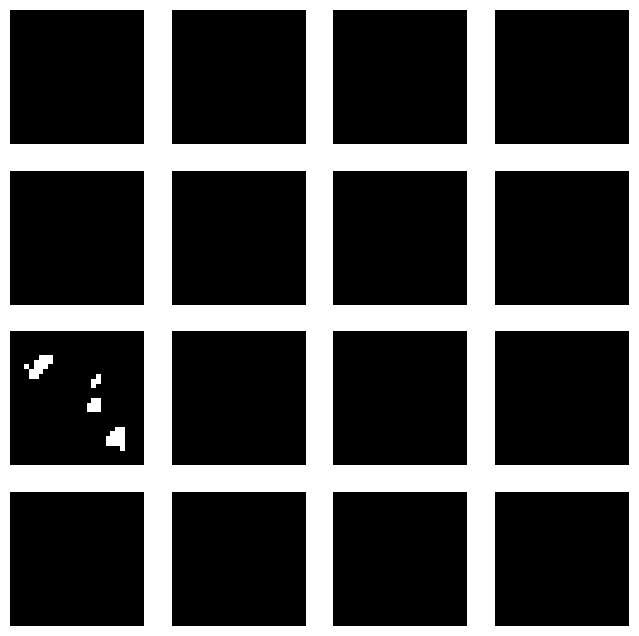

In [1]:

from utils import lire_mnist_all, plot_generated_images
from models import RBM

(X_train, y_train), (X_test, y_test) = lire_mnist_all()

dim_visible = X_train.shape[1]  # Infer p from X
dim_hidden = 500  # Hidden layer size 

# Initialize RBM
rbm = RBM(dim_visible, dim_hidden)

# Train the model
rbm.train_RBM(X_train, learning_rate=10**(-2), batch_size=32, n_epochs=50, verbose=False)

generated_images = rbm.generer_image_RBM(nb_images=16, gibbs_steps=200)  # Take only the first generated image

plot_generated_images(generated_images,image_shape=(28, 28))

Training layer 1
epoch 0/50 - loss : 0.0189191223683459
epoch 10/50 - loss : 0.008460933043699078
epoch 20/50 - loss : 0.006853606988096798
epoch 30/50 - loss : 0.00603535490724776
epoch 40/50 - loss : 0.005469353615999107
Training layer 2
epoch 0/50 - loss : 0.038036253
epoch 10/50 - loss : 0.01652251
epoch 20/50 - loss : 0.012621856
epoch 30/50 - loss : 0.011230329
epoch 40/50 - loss : 0.010534947
Training layer 3
epoch 0/50 - loss : 0.04665626
epoch 10/50 - loss : 0.024016159
epoch 20/50 - loss : 0.02156236
epoch 30/50 - loss : 0.02037064
epoch 40/50 - loss : 0.019727381
Number of images: 16


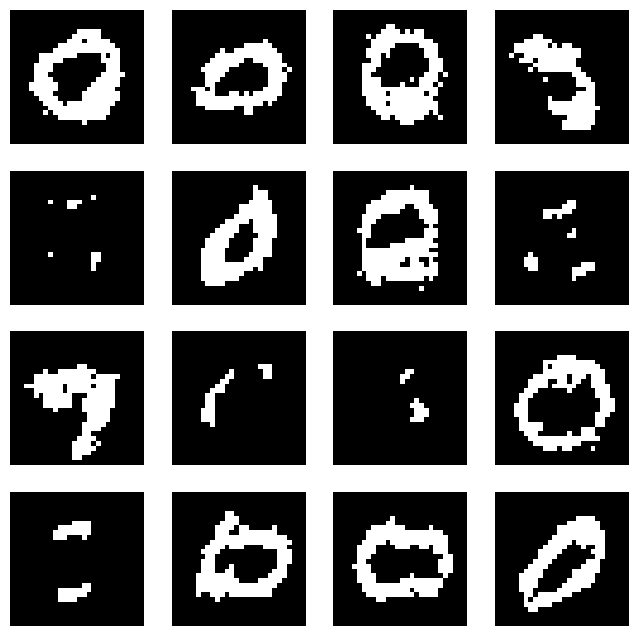

In [46]:
class DBN:
    def __init__(self, layer_sizes):
        self.L = len(layer_sizes) - 1  # number of hidden layers
        self.layer_sizes = layer_sizes
        self.layers = [RBM(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)]

    def train_DBN(self, training_set, learning_rate, batch_size, n_epochs_per_layer, verbose=False):
        for i in range(self.L):
            print(f'Training layer {i+1}')
            self.layers[i].train_RBM(training_set, learning_rate, batch_size, n_epochs_per_layer, verbose)
            training_set = self.layers[i].entree_sortie_RBM(training_set)

    def generer_image_DBN(self, nb_images, gibbs_steps, size_img=(28, 28)):
        p = self.layers[0].W.shape[0]  # Input layer size
        images = []
        for _ in range(nb_images):
            # Initialize a random visible vector
            v = (np.random.rand(1, p) < 0.5).astype(np.float32)  # Ensure (1, p) shape
            
            for _ in range(gibbs_steps):
                # Propagate upwards through the DBN (visible → hidden)
                for rbm in self.layers:
                    v = rbm.entree_sortie_RBM(v)  # Hidden activation
                    v = (np.random.rand(*v.shape) < v).astype(np.float32)  # Sample binary hidden state

                # Propagate downwards through the DBN (hidden → visible)
                for rbm in reversed(self.layers):
                    v = rbm.sortie_entree_RBM(v)  # Visible activation
                    v = (np.random.rand(*v.shape) < v).astype(np.float32)  # Sample binary visible state
            
            # Reshape the final visible layer back to an image
            images.append(v.reshape(size_img))
        return images
def lire_mnist_all():
    """
    Read all the data from the MNIST dataset.

    Returns:
    X_train, y_train: Training data and labels (flattened images)
    X_test, y_test: Test data and labels (flattened images)
    """
    # Load data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Flatten images
    X_train = X_train.reshape(-1, 28*28)
    X_test = X_test.reshape(-1, 28*28)

    # Binarize
    X_train = (X_train > 127).astype(int)
    X_test = (X_test > 127).astype(int)

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = lire_mnist_all()
dim_visible = X_train.shape[1]  # Infer p from X
layer_sizes = [dim_visible, 500, 250, 100]  # Example structure

# Initialize and train DBN
dbn = DBN(layer_sizes)
dbn.train_DBN(X_train, learning_rate=0.01, batch_size=10, n_epochs_per_layer=50, verbose=True)

# Generate and visualize images
images= dbn.generer_image_DBN(nb_images=16, gibbs_steps=200)
plot_generated_images(images, image_shape=(28, 28))


In [ ]:
from utils import deriv_cross_soft,deriv_sigmoid
def deriv_sigmoid(x):
    """
    calculate the derivative of the sigmoid function

    args:
    x: sigmoid(a)

    return:
    output: the derivative sigmoid'(a) = sigmoid(a)*(1 - sigmoid(a))
    """

    return x*(1 - x)


def deriv_cross_soft(y_soft, y_true):
    """
    calculate the derivative of the cross entropy loss of the softmax

    args:
    y_true: the true labels
    y_soft: the output of the softmax (softmax(Z))

    return:
    output: the derivative of the {cross entropy + softmax} wrt Z
    """

    return y_soft-y_true
class DNN(DBN):
    def __init__(self, layer_sizes):
        super().__init__(layer_sizes[:-1])  # Use DBN's initialization

        self.dim_output = layer_sizes[-1]  # Number of output classes
        self.b_out = np.zeros((1, self.dim_output))
        self.W_out = np.random.randn(self.layer_sizes[-1], self.dim_output)*0.1

    def calcul_softmax(self, input, W, b):  # ✅ FIX: Added `self`
        output = np.dot(input, W) + b
        output = np.exp(output - np.max(output, axis=1, keepdims=True))  # ✅ Numerical stability fix
        output = output / np.sum(output, axis=1, keepdims=True)
        return output

    def pretrain_DNN(self, training_data,learning_rate, batch_size, n_epochs_per_layer,verbose=False):
        self.train_DBN(training_data, learning_rate, batch_size, n_epochs_per_layer, verbose)

    def entree_sortie_reseau(self, input):
        all_layers_list = [input]
        for i in range(self.L):
            h = self.layers[i].entree_sortie_RBM(all_layers_list[i])
            all_layers_list.append(h)

        output = self.calcul_softmax(h, self.W_out, self.b_out)
        all_layers_list.append(output)

        return all_layers_list

    def retropropagation(self, data, target, batch_size, n_epochs, lr):
        # one-hot encode the target
        target = np.eye(self.dim_output)[target]

        for epoch in range(n_epochs):
            for i_start in range(0, data.shape[0], batch_size):
                i_end = min(data.shape[0], i_start + batch_size)
                batch = data[i_start:i_end]
                batch_target = target[i_start:i_end]

                # forward pass
                all_layers_list = self.entree_sortie_reseau(batch)
                output = all_layers_list[-1]

                # loss
                cross_entropy = -np.sum(batch_target*np.log(output), axis=1)
                loss = np.mean(cross_entropy)

                # backpropagation (delta is used to compute gradients)
                delta = [deriv_cross_soft(output, y_true=batch_target)]
                delta = [np.dot(delta[0], self.W_out.T) *
                         deriv_sigmoid(all_layers_list[-2])] + delta
                for i in range(3, self.L+2):
                    delta = [np.dot(delta[0], self.layers[-i+2].W.T) *
                             deriv_sigmoid(all_layers_list[-i])] + delta
                # len(delta) is self.L+1, first is input transform

                # update
                grad_W_out = np.dot(all_layers_list[-2].T, delta[-1])
                grad_W_out = grad_W_out / (i_end - i_start)
                grad_b_out = np.mean(delta[-1], axis=0)

                self.W_out -= lr*grad_W_out
                self.b_out -= lr*grad_b_out

                for i in range(self.L):
                    grad_W = np.dot(all_layers_list[i].T, delta[i])
                    grad_W = grad_W / (i_end - i_start)
                    grad_b = np.mean(delta[i], axis=0)

                    self.layers[i].W -= lr*grad_W
                    self.layers[i].b -= lr*grad_b

            # show epoch error
            print(f'Epoch {epoch}, Cross-Entropy Loss: {loss}')
            # Show epoch error



    def test_DNN(self, data, target):
        output = self.entree_sortie_reseau(data)[-1]
        pred = np.argmax(output, axis=1)

        accuracy = np.mean(pred == target)

        return accuracy

Epoch 0, Cross-Entropy Loss: 0.15625425203132332
Epoch 1, Cross-Entropy Loss: 0.0883223421936342
Epoch 2, Cross-Entropy Loss: 0.06209503125224165
Epoch 3, Cross-Entropy Loss: 0.04760150408367081
Epoch 4, Cross-Entropy Loss: 0.03839272551864718
Epoch 5, Cross-Entropy Loss: 0.03249966276668502
Epoch 6, Cross-Entropy Loss: 0.028483632990303126
Epoch 7, Cross-Entropy Loss: 0.025388052329269363
Epoch 8, Cross-Entropy Loss: 0.022775063804029785
Epoch 9, Cross-Entropy Loss: 0.02049195731328282
Epoch 10, Cross-Entropy Loss: 0.018447400267436825
Epoch 11, Cross-Entropy Loss: 0.016565674869199708
Epoch 12, Cross-Entropy Loss: 0.01480279503941108
Epoch 13, Cross-Entropy Loss: 0.01315211050326943
Epoch 14, Cross-Entropy Loss: 0.011632299523086606
Epoch 15, Cross-Entropy Loss: 0.010265290730926257
Epoch 16, Cross-Entropy Loss: 0.0090600468946953
Epoch 17, Cross-Entropy Loss: 0.008010295491020706
Epoch 18, Cross-Entropy Loss: 0.007100188301513741
Epoch 19, Cross-Entropy Loss: 0.006310329952036269
Ep

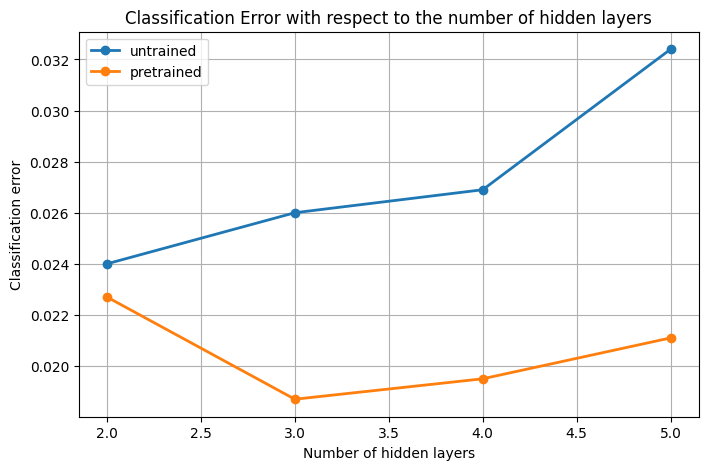

In [57]:

import numpy as np
import matplotlib.pyplot as plt
def lire_mnist_all():
    """
    Read all the data from the MNIST dataset.

    Returns:
    X_train, y_train: Training data and labels (flattened images)
    X_test, y_test: Test data and labels (flattened images)
    """
    # Load data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Flatten images
    X_train = X_train.reshape(-1, 28*28)
    X_test = X_test.reshape(-1, 28*28)

    # Binarize
    X_train = (X_train > 127).astype(int)
    X_test = (X_test > 127).astype(int)

    return (X_train, y_train), (X_test, y_test)
# Define different architectures with increasing hidden layers
architectures = [
    [784, 200, 200, 10],         # 2 hidden layers
    [784, 200, 200, 200, 10],    # 3 hidden layers
    [784, 200, 200, 200, 200, 10], # 4 hidden layers
    [784, 200, 200, 200, 200, 200, 10] # 5 hidden layers
]

# Training parameters
batch_size = 32
lr = 0.1
n_epochs_pretrain = 300
n_epochs_train = 100

# Load alpha digit data
(X_train, y_train), (X_test, y_test) = lire_mnist_all()
n_classes = len(np.unique(y_train))

# Store classification errors
errors_untrained = []
errors_pretrained = []

for arch in architectures:
    # Train untrained model (without pretraining)
    dnn_untrained = DNN(arch)
    dnn_untrained.retropropagation(X_train, y_train, batch_size, n_epochs_train, lr)
    error_untrained = 1 - dnn_untrained.test_DNN(X_test, y_test)
    errors_untrained.append(error_untrained)

    # Train pretrained model
    dnn_pretrained = DNN(arch)
    print(f'Pretraining for architecture: {arch}')
    dnn_pretrained.pretrain_DNN(X_train, lr, batch_size, n_epochs_pretrain)
    dnn_pretrained.retropropagation(X_train, y_train, batch_size, n_epochs_train, lr)
    error_pretrained = 1 - dnn_pretrained.test_DNN(X_test, y_test)
    errors_pretrained.append(error_pretrained)

# Convert number of layers to a readable format
hidden_layers_count = [len(arch) - 2 for arch in architectures]  # Excluding input & output layers

# Plot the classification error
plt.figure(figsize=(8, 5))
plt.plot(hidden_layers_count, errors_untrained, label='untrained', marker='o', linestyle='-', linewidth=2)
plt.plot(hidden_layers_count, errors_pretrained, label='pretrained', marker='o', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel("Number of hidden layers")
plt.ylabel("Classification error")
plt.title("Classification Error with respect to the number of hidden layers")
plt.legend()

# Show plot
plt.grid()
plt.show()


Epoch 0, Cross-Entropy Loss: 0.17162043380994355
Epoch 1, Cross-Entropy Loss: 0.10602162458664491
Epoch 2, Cross-Entropy Loss: 0.07725025056025422
Epoch 3, Cross-Entropy Loss: 0.06173458299309653
Epoch 4, Cross-Entropy Loss: 0.051364817701011645
Epoch 5, Cross-Entropy Loss: 0.043466600066723184
Epoch 6, Cross-Entropy Loss: 0.03777130197523184
Epoch 7, Cross-Entropy Loss: 0.03403607818028058
Epoch 8, Cross-Entropy Loss: 0.03168412715005102
Epoch 9, Cross-Entropy Loss: 0.03010292582304314
Epoch 10, Cross-Entropy Loss: 0.028788017476271383
Epoch 11, Cross-Entropy Loss: 0.02741432885403674
Epoch 12, Cross-Entropy Loss: 0.025857794996736842
Epoch 13, Cross-Entropy Loss: 0.0241552250395905
Epoch 14, Cross-Entropy Loss: 0.02243085069967171
Epoch 15, Cross-Entropy Loss: 0.020821244277196234
Epoch 16, Cross-Entropy Loss: 0.019421779918508734
Epoch 17, Cross-Entropy Loss: 0.018266438458875836
Epoch 18, Cross-Entropy Loss: 0.01733329709438575
Epoch 19, Cross-Entropy Loss: 0.016561433365444304
Epo

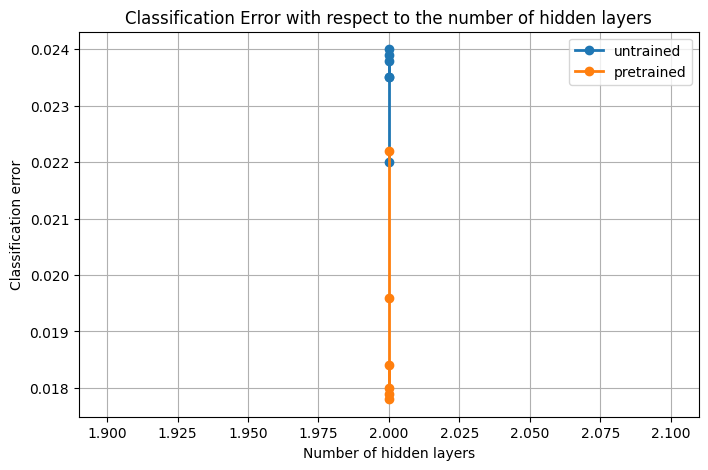

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define different architectures with increasing hidden layers
architectures = [
    [784, 200, 200, 10],  # 2 hidden layers
    [784, 300, 300, 10],  # 3 hidden layers
    [784, 400, 400,  10], # 4 hidden layers
    [784, 500, 500,  10], # 5 hidden layers
    [784, 600, 600,  10], # 6 hidden layers
    [784, 700, 700,  10], # 7 hidden layers
]

# Training parameters
batch_size = 32
lr = 0.1
n_epochs_pretrain = 200
n_epochs_train = 200

# Load alpha digit data
(X_train, y_train), (X_test, y_test) = lire_mnist_all()
n_classes = len(np.unique(y_train))

# Store classification errors
errors_untrained = []
errors_pretrained = []

for arch in architectures:
    # Train untrained model (without pretraining)
    dnn_untrained = DNN(arch)
    dnn_untrained.retropropagation(X_train, y_train, batch_size, n_epochs_train, lr)
    error_untrained = 1 - dnn_untrained.test_DNN(X_test, y_test)
    errors_untrained.append(error_untrained)

    # Train pretrained model
    dnn_pretrained = DNN(arch)
    print(f'Pretraining for architecture: {arch}')
    dnn_pretrained.pretrain_DNN(X_train, lr, batch_size, n_epochs_pretrain)
    dnn_pretrained.retropropagation(X_train, y_train, batch_size, n_epochs_train, lr)
    error_pretrained = 1 - dnn_pretrained.test_DNN(X_test, y_test)
    errors_pretrained.append(error_pretrained)

# Convert number of layers to a readable format
hidden_layers_count = [200,300,400, 500,600,700]  # Excluding input & output layers

# Plot the classification error
plt.figure(figsize=(8, 5))
plt.plot(hidden_layers_count, errors_untrained, label='untrained', marker='o', linestyle='-', linewidth=2)
plt.plot(hidden_layers_count, errors_pretrained, label='pretrained', marker='o', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel("Number of hidden layers")
plt.ylabel("Classification error")
plt.title("Classification Error with respect to the number of hidden layers")
plt.legend()

# Show plot
plt.grid()
plt.show()

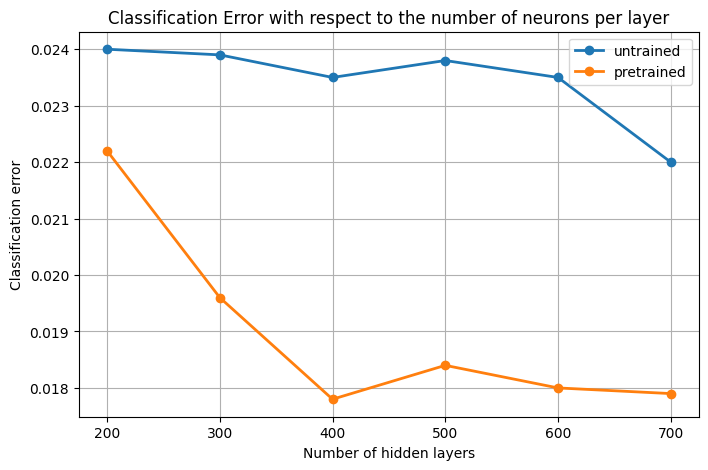

In [63]:
# Convert number of layers to a readable format
hidden_layers_count = [200,300,400,500,600,700]  # Excluding input & output layers

# Plot the classification error
plt.figure(figsize=(8, 5))
plt.plot(hidden_layers_count, errors_untrained, label='untrained', marker='o', linestyle='-', linewidth=2)
plt.plot(hidden_layers_count, errors_pretrained, label='pretrained', marker='o', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel("Number of hidden layers")
plt.ylabel("Classification error")
plt.title("Classification Error with respect to the number of neurons per layer")
plt.legend()

# Show plot
plt.grid()
plt.show()

Epoch 0, Cross-Entropy Loss: 2.1723090754561647
Epoch 1, Cross-Entropy Loss: 2.03620744556671
Epoch 2, Cross-Entropy Loss: 1.8795182138454558
Epoch 3, Cross-Entropy Loss: 1.6916666273879981
Epoch 4, Cross-Entropy Loss: 1.4751034787966457
Epoch 5, Cross-Entropy Loss: 1.2493945746817516
Epoch 6, Cross-Entropy Loss: 1.0413104586609916
Epoch 7, Cross-Entropy Loss: 0.8681386872839437
Epoch 8, Cross-Entropy Loss: 0.7328706652453159
Epoch 9, Cross-Entropy Loss: 0.6303046870190709
Epoch 10, Cross-Entropy Loss: 0.5532277871678464
Epoch 11, Cross-Entropy Loss: 0.4951512405502514
Epoch 12, Cross-Entropy Loss: 0.4509470978888454
Epoch 13, Cross-Entropy Loss: 0.4167483180817477
Epoch 14, Cross-Entropy Loss: 0.38968680128087285
Epoch 15, Cross-Entropy Loss: 0.3676463955293579
Epoch 16, Cross-Entropy Loss: 0.3490715498935297
Epoch 17, Cross-Entropy Loss: 0.3328283895604626
Epoch 18, Cross-Entropy Loss: 0.3181052249750582
Epoch 19, Cross-Entropy Loss: 0.30433941542158005
Epoch 20, Cross-Entropy Loss: 

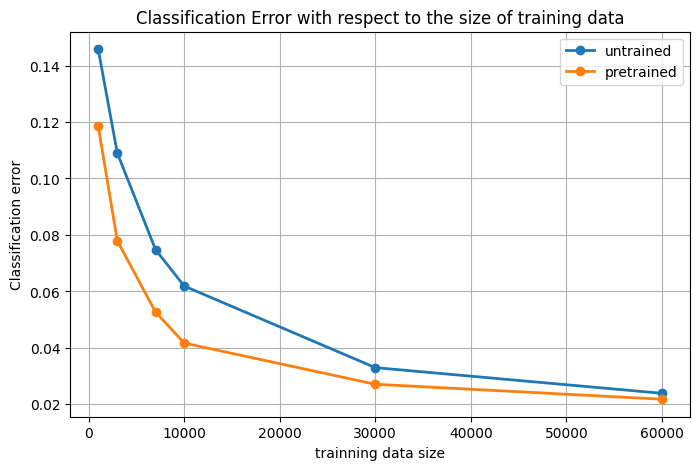

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset using the provided function
def lire_mnist_all():
    """
    Read all the data from the MNIST dataset.

    Returns:
    X_train, y_train: Training data and labels (flattened images)
    X_test, y_test: Test data and labels (flattened images)
    """
    # Load data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Flatten images
    X_train = X_train.reshape(-1, 28*28)
    X_test = X_test.reshape(-1, 28*28)

    # Binarize
    X_train = (X_train > 127).astype(int)
    X_test = (X_test > 127).astype(int)

    return (X_train, y_train), (X_test, y_test)

# Load data
(X_train, y_train), (X_test, y_test) = lire_mnist_all()

# Define different training set sizes
train_sizes = [1000, 3000, 7000, 10000, 30000, 60000]

# Fixed architecture (2 layers with 200 neurons each)
architecture = [784, 200, 200, 10]

# Training parameters
batch_size = 32
lr = 0.1
n_epochs_pretrain = 200
n_epochs_train = 200

# Store classification errors
errors_untrained_size = []
errors_pretrained_size = []

# Train and evaluate the model for different training set sizes
for size in train_sizes:
    # Get a random subset of the training data
    X_train_subset=X_train[:size]
    y_train_subset=y_train[:size]


    # Train untrained model (without pretraining)
    dnn_untrained = DNN(architecture)
    dnn_untrained.retropropagation(X_train_subset, y_train_subset, batch_size, n_epochs_train, lr)
    error_untrained = 1 - dnn_untrained.test_DNN(X_test, y_test)
    errors_untrained_size.append(error_untrained)

    # Train pretrained model
    dnn_pretrained = DNN(architecture)
    print(f'Pretraining for size: {size}')
    dnn_pretrained.pretrain_DNN(X_train_subset, lr, batch_size, n_epochs_pretrain)
    dnn_pretrained.retropropagation(X_train_subset, y_train_subset, batch_size, n_epochs_train, lr)
    error_pretrained = 1 - dnn_pretrained.test_DNN(X_test, y_test)
    errors_pretrained_size.append(error_pretrained)

# Plot the classification error
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, errors_untrained_size, label='untrained', marker='o', linestyle='-', linewidth=2)
plt.plot(train_sizes, errors_pretrained_size, label='pretrained', marker='o', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel("trainning data size")
plt.ylabel("Classification error")
plt.title("Classification Error with respect to the size of training data")
plt.legend()

# Show plot
plt.grid()
plt.show()


Epoch [1/200], Loss D: 0.2308, Loss G: 6.6124
Epoch [2/200], Loss D: 0.8066, Loss G: 2.1084
Epoch [3/200], Loss D: 0.2501, Loss G: 3.7890
Epoch [4/200], Loss D: 0.6021, Loss G: 4.2358
Epoch [5/200], Loss D: 0.0957, Loss G: 5.0330
Epoch [6/200], Loss D: 0.2422, Loss G: 7.0976
Epoch [7/200], Loss D: 0.2220, Loss G: 6.9299
Epoch [8/200], Loss D: 0.3322, Loss G: 4.6194
Epoch [9/200], Loss D: 0.1714, Loss G: 5.2742
Epoch [10/200], Loss D: 0.7600, Loss G: 5.6443
Epoch [11/200], Loss D: 0.7692, Loss G: 2.9723
Epoch [12/200], Loss D: 0.1921, Loss G: 3.6830
Epoch [13/200], Loss D: 0.4717, Loss G: 3.7558
Epoch [14/200], Loss D: 0.2589, Loss G: 4.4849
Epoch [15/200], Loss D: 0.3731, Loss G: 4.3294
Epoch [16/200], Loss D: 0.1668, Loss G: 3.1045
Epoch [17/200], Loss D: 0.2185, Loss G: 4.9562
Epoch [18/200], Loss D: 0.3470, Loss G: 3.7116
Epoch [19/200], Loss D: 0.5895, Loss G: 3.1411
Epoch [20/200], Loss D: 0.5101, Loss G: 2.4659
Epoch [21/200], Loss D: 0.3757, Loss G: 3.9805
Epoch [22/200], Loss D

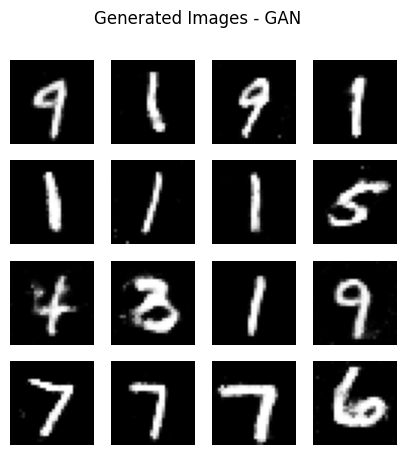

In [12]:
# ================================
# 1. GAN Model
# ================================
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, 784))

# GAN Training
def train_gan(generator, discriminator, epochs=200):
    loss_fn = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

    for epoch in range(epochs):
        for real_images, _ in train_loader:
            batch_size = real_images.shape[0]

            # Generate fake images
            z = torch.randn(batch_size, 100)
            fake_images = generator(z)

            # Train Discriminator
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            d_real = discriminator(real_images)
            d_fake = discriminator(fake_images.detach())
            loss_d = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)

            optimizer_d.zero_grad()
            loss_d.backward()
            optimizer_d.step()

            # Train Generator
            output = discriminator(fake_images)
            loss_g = loss_fn(output, real_labels)

            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")
def generate_gan_images(generator, num_samples=16):
    generator.eval()
    z = torch.randn(num_samples, 100)  # Generate random latent vectors
    with torch.no_grad():
        fake_images = generator(z).cpu()
    fake_images = (fake_images + 1) / 2  # Rescale images from [-1,1] to [0,1]
    
    # Plot images
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.suptitle("Generated Images - GAN")
    plt.show()
    
generator = Generator()
discriminator = Discriminator()
train_gan(generator, discriminator)
generate_gan_images(generator)




Epoch [1/200], Loss: 8295093.1924
Epoch [2/200], Loss: 7075820.3157
Epoch [3/200], Loss: 6901215.4233
Epoch [4/200], Loss: 6802533.6904
Epoch [5/200], Loss: 6728842.2932
Epoch [6/200], Loss: 6671145.8853
Epoch [7/200], Loss: 6625641.9775
Epoch [8/200], Loss: 6585301.0825
Epoch [9/200], Loss: 6558859.5244
Epoch [10/200], Loss: 6532142.4688
Epoch [11/200], Loss: 6510703.2085
Epoch [12/200], Loss: 6490154.4885
Epoch [13/200], Loss: 6474395.7373
Epoch [14/200], Loss: 6458777.7603
Epoch [15/200], Loss: 6443358.3152
Epoch [16/200], Loss: 6434696.3171
Epoch [17/200], Loss: 6422265.1748
Epoch [18/200], Loss: 6412967.8337
Epoch [19/200], Loss: 6401644.6616
Epoch [20/200], Loss: 6393303.7607
Epoch [21/200], Loss: 6381970.7256
Epoch [22/200], Loss: 6380061.1667
Epoch [23/200], Loss: 6372127.9316
Epoch [24/200], Loss: 6366242.4624
Epoch [25/200], Loss: 6357034.9941
Epoch [26/200], Loss: 6355918.3955
Epoch [27/200], Loss: 6348587.6079
Epoch [28/200], Loss: 6345293.3401
Epoch [29/200], Loss: 6340185

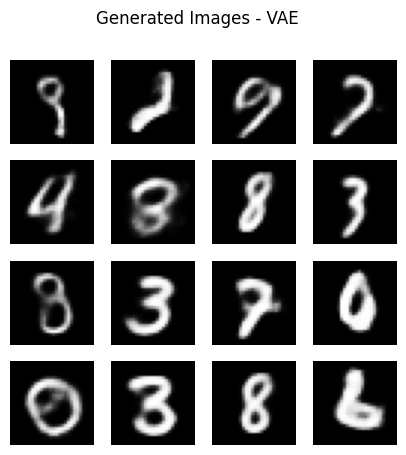

In [13]:
# ================================
# 2. Variational Autoencoder (VAE)
# ================================
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 20)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        z_mean, z_log_var = self.encoder(x).chunk(2, dim=1)
        z = z_mean + torch.exp(0.5 * z_log_var) * torch.randn_like(z_mean)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z_mean, z_log_var

def vae_loss(x_reconstructed, x, z_mean, z_log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x.view(-1, 784), reduction="sum")
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return reconstruction_loss + kl_divergence

def train_vae(vae, epochs=200):
    optimizer = optim.Adam(vae.parameters(), lr=0.002)
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.view(-1, 784)  # Flatten
            images = (images - images.min()) / (images.max() - images.min())  # Normalize to [0,1]

            x_reconstructed, z_mean, z_log_var = vae(images)
            loss = vae_loss(x_reconstructed, images, z_mean, z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

def generate_vae_images(vae, num_samples=16):
    vae.eval()
    z = torch.randn(num_samples, 10)  # Sample from normal distribution in latent space
    with torch.no_grad():
        generated_images = vae.decoder(z).cpu().view(-1, 28, 28)
    
    # Plot images
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap="gray")
        ax.axis("off")
    plt.suptitle("Generated Images - VAE")
    plt.show()
vae = VAE()
train_vae(vae)
generate_vae_images(vae)




C:\Users\JLASSI\AppData\Local\Temp\ipykernel_27092\1144599428.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.dev

Pretrained diffusion model loaded successfully!


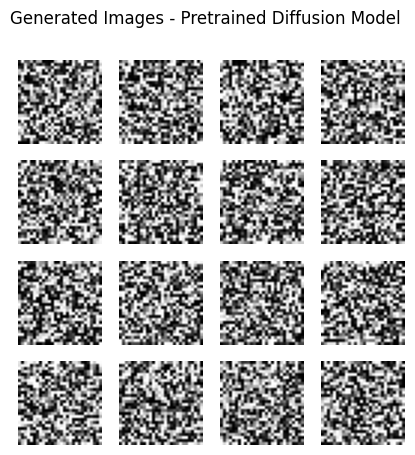

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ✅ Custom U-Net (Modify based on original training config)
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
        )
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        x = self.init_conv(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.up1(x)
        x = self.up2(x)
        return self.final_conv(x)

# ✅ Load the pretrained model
def load_pretrained_model(model_path):
    model = UNet()
    checkpoint = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    model.load_state_dict(checkpoint, strict=False)  # strict=False to ignore mismatched keys
    model.eval()
    return model

# Load your model
model_path = "ddpm_unet.pth"
diffusion_model = load_pretrained_model(model_path)
print("Pretrained diffusion model loaded successfully!")
from diffusers import DDPMScheduler

# ✅ Define the scheduler
scheduler = DDPMScheduler(num_train_timesteps=10000)

# ✅ Generate images using the pretrained model
def generate_images(model, scheduler, num_samples=16):
    # ✅ Get the device from the model parameters
    device = next(model.parameters()).device
    model.to(device)

    # Start with pure noise
    latents = torch.randn((num_samples, 1, 28, 28), device=device)

    for t in scheduler.timesteps:
        with torch.no_grad():
            noise_pred = model(latents, t)  # Predict noise
        latents = scheduler.step(noise_pred, t, latents).prev_sample  # Denoising step

    # Convert to numpy for visualization
    latents = latents.cpu().numpy().squeeze()

    # ✅ Display images
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(latents[i], cmap="gray")
        ax.axis("off")
    plt.suptitle("Generated Images - Pretrained Diffusion Model")
    plt.show()
generate_images(diffusion_model, scheduler)


